In [16]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [17]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse

#### Load file with all core specifications

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
lat = np.array([71.12038,70.30,77.17972,70.63491,70.65081,70.67700,70.63980,71.75926,71.49200,71.15495,70.86510])
lon = np.array([322.68364,315.00000,298.89026,324.18001,322.52121,321.21300,320.38222,324.14947,324.11877,324.16227,324.16187])
elev = np.array([3172,2410,1880,3092,3138,3072,3018,3087,3092,3098,3102])
T10m = -np.array([30.40,22.30,24.29,29.41,29.77,29.07,28.30,30.37,30.42,30.10,29.59])
T20m = -np.array([30.16,0,24.35,29.41,29.48,28.54,27.89,30.41,30.36,30.01,29.53])
coreLength = np.array([404.0,398.0,100.1,128.6,105.6,24.9,100.1,77.8,25.7,70.8,26.2])
drillYr = np.array([1974,1973,1977,1985,1984,1984,1984,1985,1985,1985,1985])

#CoresSpecs['lat'] = lat
#CoresSpecs['lon'] = lon
#CoresSpecs['elev'] = elev
#CoresSpecs['T10m'] = T10m
#CoresSpecs['T20m'] = T20m
#CoresSpecs['coreLength'] = coreLength
#CoresSpecs['drillYr'] = drillYr

#print(CoresSpecs.to_latex(index=False))

#CoresSpecs2 = CoresSpecs.drop('z0', axis=1)
#CoresSpecs2.drop('dens0',axis=1)

#CoresSpecs2 = CoresSpecs2[['CoreName','drillYr', 'coreLength', 'lat', 'lon','elev','dLaki', 'dTamb', 'Accum0', 'T0', 'T10m', 'T20m']]
#CoresSpecs2 = CoresSpecs2[[]]
#CoresSpecs2.to_csv('/home/thea/MesterTesen/Data/CoreSpecs2.txt', index=None, sep=',')
#print(CoresSpecs2.to_latex(index=False))

#### Choose site and get specifications from given site.

In [21]:
coreNames = CoresSpecs['CoreName']

site = 'SiteA'
core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = np.float64(CoreSpecs['dTamb'])
dLaki = np.float64(CoreSpecs['dLaki'])
Accum0 = np.float64(CoreSpecs['Accum0'])
T0 = np.float64(CoreSpecs['T0'])
dens0 = np.float64(CoreSpecs['dens0'])
z0 = np.float64(CoreSpecs['z0'])


#### Get profiles available

In [22]:
site_Dens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+ site + 'DepthDens_w_Models.txt', '\t')
site_Diff = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+ site + '_DepthDiff.txt', '\t')
site_ECM = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetECM/'+ site + '_ECM.txt', ',') 
site_d18O =  pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+ site + '_det.txt', ',')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Rename arrays

In [23]:

    # Define diffusion length measurements: o18, o17 and D. Define btw. Laki and Tamb.
depthDiff = site_Diff['Depth']
sigma_D = site_Diff['sigma_D']
sigma_o18 = site_Diff['sigma_o18']
sigma_o17 = site_Diff['sigma_o17']
depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o18_LT = sigma_o18[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_o17_LT = sigma_o17[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
sigma_D_LT = sigma_D[(depthDiff >= dTamb) & (depthDiff <= dLaki)]

    # Define ECM data. Define btw. Laki and Tamb.
depthECM = site_ECM['depth']
ECM = site_ECM['ECM']
depthECM_LT = depthECM[(depthECM >= dTamb) & (depthECM <= dLaki)]
ECM_LT = ECM[(depthECM >= dTamb) & (depthECM <= dLaki)]

    # Define d18O details data. Define btw. Laki and Tamb.
depth = site_d18O['depth'][1:]
d18O = site_d18O['d18O'][1:]
depth_LT = site_d18O['depth'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]
d18O_LT = site_d18O['d18O'][(site_d18O['depth'] >= dTamb) & (site_d18O['depth'] <= dLaki)]

    # Define density measurements: raw, model and fudged model. Define btw. Laki and Tamb.
depthRho = site_Dens['depth']
depthRho_LT = depthRho[(depthRho >= dTamb) & (depthRho <= dLaki)]

HLmodel = site_Dens['HLmodel']
HLmodel_LT = HLmodel[(depthRho >= dTamb) & (depthRho <= dLaki)]

HLmodelOpti = site_Dens['HLmodelOpti']
HLmodelOpti_LT =HLmodelOpti[(depthRho >= dTamb) & (depthRho <= dLaki)]
rhoMeas = site_Dens['rhoMeas']
rhoMeas_LT = rhoMeas[(depthRho >= dTamb) & (depthRho <= dLaki)]


# Density and diffusion length profiles

#### Plot depth/density profile

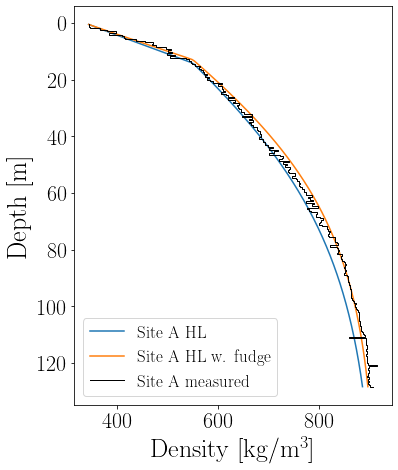

In [24]:
fig1, ax1 = plt.subplots(figsize=(6,7))

ax1.set_xlabel('Density [kg/m$^3$]',fontsize=26) 
ax1.set_ylabel('Depth [m]', fontsize=26)
ax1.invert_yaxis()
ax1.plot(HLmodel*1000, depthRho, label='Site A HL')
ax1.plot(HLmodelOpti*1000, depthRho, label=f'Site A HL w. fudge')#\nf0 = {f0:.2f} f1 = {f1:.2f}')

ax1.step(rhoMeas, depthRho,'k',lw=1,label='Site A measured')
ax1.legend(fontsize=17)
fig1.tight_layout()
saveFigs=True
if saveFigs:
    fig1.savefig('../../WrittenWork/Figures/' + site + '_DensProfile_wHL.pdf', bbox_inches='tight')

#### Plot depth/diffusion length profile

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Max sigma, theoretically: 0.079
Min sigma, theoretically: 0.077


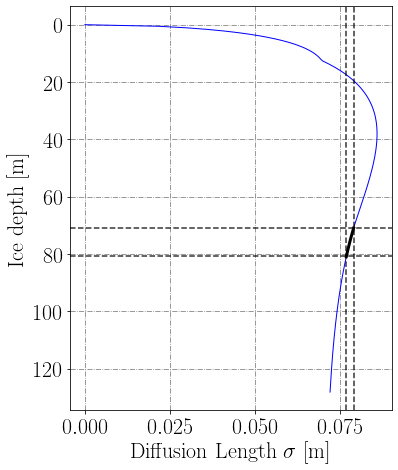

In [26]:
figDiff, axDiff = plt.subplots(figsize=(6,7))

axDiff.set(xlabel='Diffusion Length $\sigma$ [m]', ylabel='Ice depth [m]')
axDiff.invert_yaxis()
axDiff.plot(sigma_o18,depthDiff, 'b', lw=1)
axDiff.plot(sigma_o18_LT,depthDiff_LT, 'k', lw=3)
axDiff.axhline(y = dTamb, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axhline(y = dLaki, alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_o18_LT.values[0], alpha=0.8, color='k', ls='--', lw=1.5)
axDiff.axvline(x = sigma_o18_LT.values[-1], alpha=0.8, color='k', ls='--', lw=1.5)

axDiff.grid(True, color='grey',ls='-.')
figDiff.tight_layout()
#if saveFigs:
#    figDiff.savefig('../../WrittenWork/NovemberPresentation/SiteA_DiffLen.jpg')
sigmaMax_theo = sigma_o18_LT.max()
sigmaMin_theo = sigma_o18_LT.min()
print(f'Max sigma, theoretically: {sigma_o18_LT.max():.3f}')
print(f'Min sigma, theoretically: {sigma_o18_LT.min():.3f}')

if saveFigs:
    figDiff.savefig('../../WrittenWork/Figures/' + site + '_DiffProfile.pdf', bbox_inches='tight')

# Plot raw data + resampled interpolated data 

In [27]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = round(min(diff), 3)
    print(min(diff))
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat, Delta


depth_LT_int, d18O_LT_int, Delta = interpCores(np.asarray(depth_LT)[0], np.asarray(depth_LT)[-1], depth_LT, d18O_LT)

0.03799999999998249


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


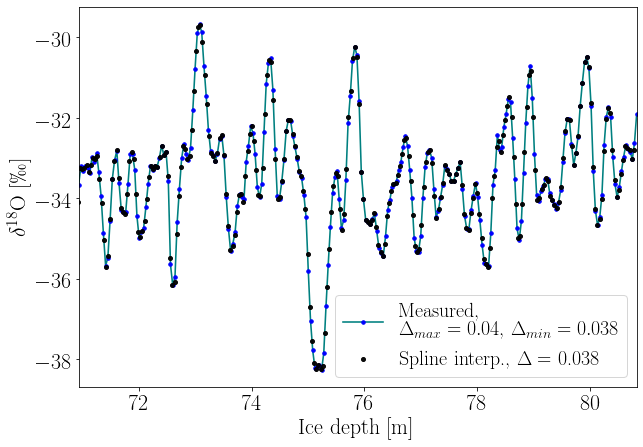

In [30]:
fig_IsoLT, ax_IsoLT = plt.subplots(figsize=(10,7))

ax_IsoLT.plot(depth_LT, d18O_LT,marker='.', color='teal', markersize=7, markeredgecolor='blue',markerfacecolor='blue',ls='-',lw=1.6, label='Measured,\n$\Delta_{max}=0.04$, $\Delta_{min}=0.038$')
ax_IsoLT.plot(depth_LT_int, d18O_LT_int, '.', color='k',markersize=8,alpha=0.95, label='Spline interp., $\Delta =$ '+f'{Delta:.3f}')
ax_IsoLT.set(xlim=(depth_LT.min(),depth_LT.max()), xlabel='Ice depth [m]',ylabel='$\delta ^{18}$O [$\permil$]')
ax_IsoLT.legend(fontsize=20)

if saveFigs:
    fig_IsoLT.savefig('../../WrittenWork/Figures/' + site + '_d18OLT_Interp.pdf', bbox_inches='tight')

# Spectral transforms plots

#### Raw PSD transform data

Diff. len., fit [cm]: 7.329


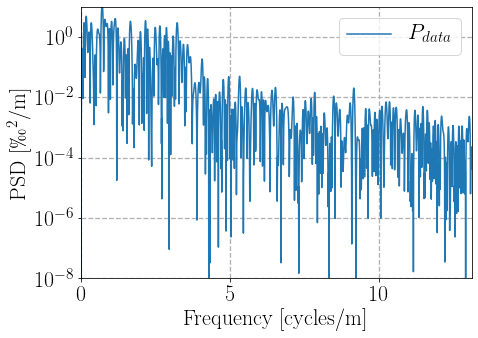

In [36]:
from Decon import SpectralDecon

decon_inst = SpectralDecon(depth_LT_int, d18O_LT_int, 2000)

w, P, Pnoise, Psignal, P_fit, opt_fit_dict, params_fit, fit_func_val, fit_dict = decon_inst.SpectralFit(printFitParams=False)

fig_dct, ax_dct = plt.subplots(figsize=(7,5))
ax_dct.semilogy(w,P, label='$P_{data}$')
ax_dct.grid(linestyle='--',lw=1.3, which='both')
ax_dct.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [$\permil$$^2$/m]', xlabel='Frequency [cycles/m]')
ax_dct.set_ylim((1e-8,10))
ax_dct.legend()

sigma_fit = opt_fit_dict['s_tot2_fit']

if saveFigs:
    fig_dct.savefig('../../WrittenWork/Figures/' + site + '_DCT_PSD_raw.pdf', bbox_inches='tight')

#### Plot fits to raw pectrum.

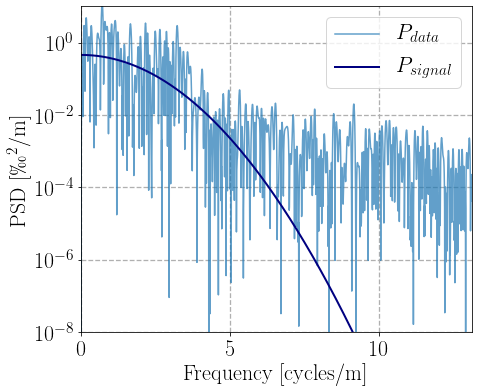

In [37]:
fig_PSDsig, ax_PSDsig = plt.subplots(figsize=(7,6))

ax_PSDsig.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDsig.semilogy(w, Psignal, label='$P_{signal}$',lw=2, color='navy')
ax_PSDsig.grid(linestyle='--',lw=1.3, which='both')
ax_PSDsig.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [$\permil$$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDsig.set_ylim((1e-8,10))
ax_PSDsig.legend()

if saveFigs:
    fig_PSDsig.savefig('../../WrittenWork/Figures/' + site + '_PSD_sig.pdf', bbox_inches='tight')


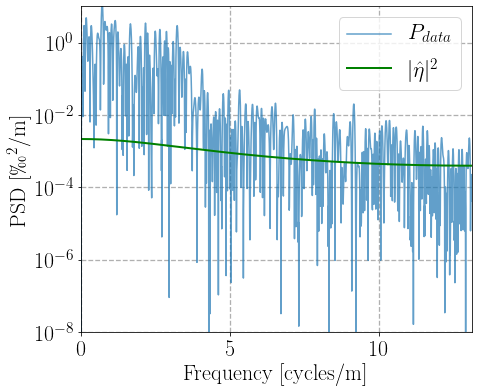

In [38]:
fig_PSDnoi, ax_PSDnoi = plt.subplots(figsize=(7,6))

ax_PSDnoi.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDnoi.semilogy(w, Pnoise, label='$|\hat{\eta}|^2$', lw=2,color='green')
ax_PSDnoi.grid(linestyle='--',lw=1.3, which='both')
ax_PSDnoi.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [$\permil$$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDnoi.set_ylim((1e-8,10))
ax_PSDnoi.legend()

if saveFigs:
    fig_PSDnoi.savefig('../../WrittenWork/Figures/' + site + '_PSD_noise.pdf', bbox_inches='tight')

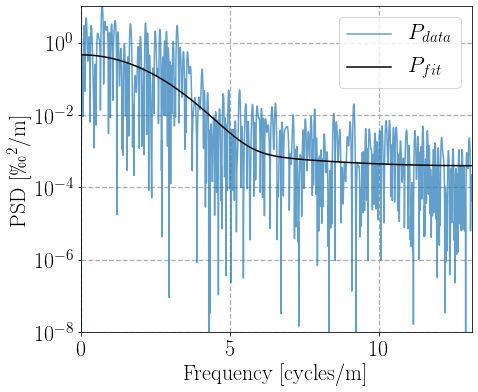

In [39]:
fig_PSDfit, ax_PSDfit = plt.subplots(figsize=(7,6))

ax_PSDfit.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDfit.semilogy(w, P_fit, color='k', label='$P_{fit}$')
ax_PSDfit.grid(linestyle='--',lw=1.3, which='both')
ax_PSDfit.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [$\permil$$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDfit.set_ylim((1e-8,10))
ax_PSDfit.legend()

if saveFigs:
    fig_PSDfit.savefig('../../WrittenWork/Figures/' + site + '_PSD_fit.pdf', bbox_inches='tight')

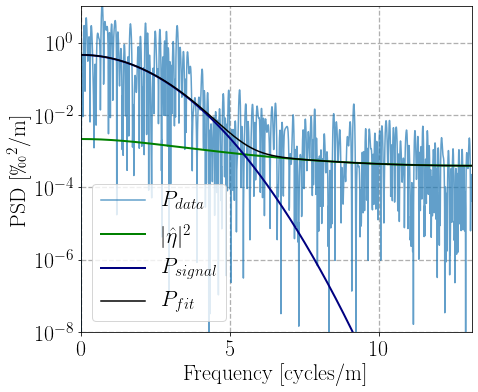

In [40]:
fig_PSDall, ax_PSDall = plt.subplots(figsize=(7,6))

ax_PSDall.semilogy(w,P, label='$P_{data}$', alpha=0.7)
ax_PSDall.semilogy(w, Pnoise, label='$|\hat{\eta}|^2$', lw=2,color='green')
ax_PSDall.semilogy(w, Psignal, label='$P_{signal}$',lw=2, color='navy')
ax_PSDall.semilogy(w, P_fit, color='k', label='$P_{fit}$')
ax_PSDall.grid(linestyle='--',lw=1.3, which='both')
ax_PSDall.set(ylim=(min(P)-min(P)*0.9, max(P)+max(P)*0.8), xlim=(min(w), max(w)),\
                    ylabel='PSD [$\permil$$^2$/m]', xlabel='Frequency [cycles/m]')
ax_PSDall.set_ylim((1e-8,10))
ax_PSDall.legend()

if saveFigs:
    fig_PSDall.savefig('../../WrittenWork/Figures/' + site + '_PSD_all.pdf', bbox_inches='tight')

# !!!! List of To-Do's for Method chapter:
- Resampling after NDCT
- (Spectral analysis DCT v. NDCT)
- Flow chart, but with figures?
- sigma_0 estimate (const. or fct.)
- Optimal sigma: (DCT/FFT/NFFT/NDCT), (Interp AF/No Interp AF), (Peaks only/Peaks AND Troughs)

# !!!! Upgrading
- Standardize + detrend
- linear timescale
- peak detection w. constraints

# Plot illustration of filter (Wiener, optimal mm.)

#### Plot created filters

In [41]:
sigma_min = 5/100
sigma_max = 8.5/100

sigma_in = np.linspace(sigma_min-0.01,sigma_max,6)
sigma_in

array([0.04 , 0.049, 0.058, 0.067, 0.076, 0.085])

In [42]:
c = []

for i in range(len(sigma_in)):
    c.append(decon_inst.Filters(sigma=sigma_in[i]))


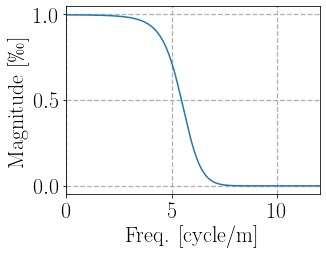

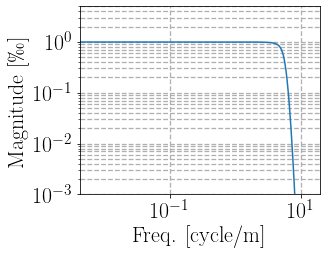

In [45]:
figWiener0, axWiener0 = plt.subplots(figsize=(5,4))

axWiener0.plot(c[0][0],c[0][1])
axWiener0.grid(linestyle='--',lw=1.3, which='both')
axWiener0.set(xlim=(0,12), xlabel='Freq. [cycle/m]', ylabel='Magnitude [$\permil$]')
figWiener0.tight_layout()


figWiener1, axWiener1 = plt.subplots(figsize=(5,4))

axWiener1.loglog(c[0][0],c[0][1])
axWiener1.grid(linestyle='--',lw=1.3, which='both')
axWiener1.set(ylim=(1e-3,5), xlabel='Freq. [cycle/m]', ylabel='Magnitude [$\permil$]')

figWiener1.tight_layout()


if saveFigs:
    figWiener0.savefig('../../WrittenWork/Figures/' + site + '_WienerFilter.pdf')
    figWiener1.savefig('../../WrittenWork/Figures/' + site + '_WienerFilter_loglog.pdf')

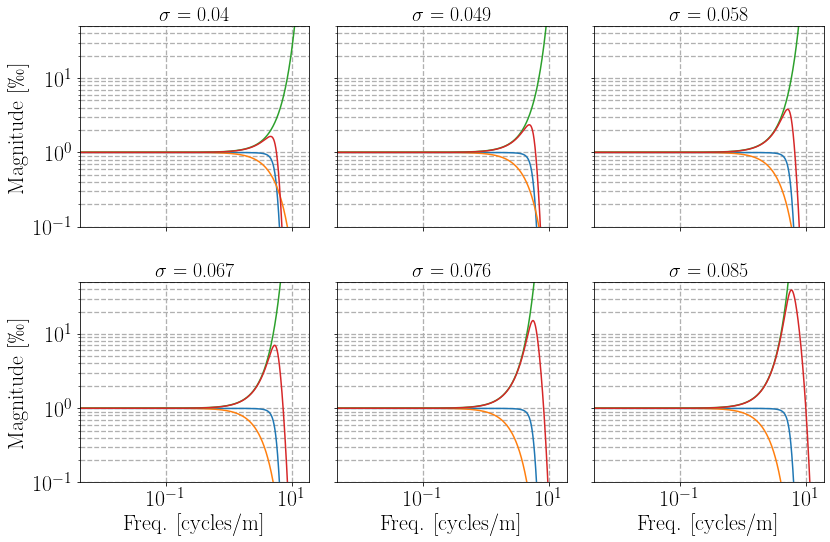

In [48]:
fig, axes = plt.subplots(2,3,figsize=(12,8), sharey=True, sharex=True)
plt.rcParams.update({'font.size': 22})

axes.titlesize:'x-large'
axes.labelsize:'large'
#plt.rcParams.update({'title.size': 18})
for i, ax in zip(range(len(sigma_in)), axes.flatten()):
    ax.grid(linestyle='--',lw=1.3, which='both')
    ax.loglog(c[i][0], c[i][1])
    ax.loglog(c[i][0], c[i][2])
    ax.loglog(c[i][0], c[i][2]**(-1))
    ax.loglog(c[i][0], c[i][3])
    ax.set_title('$\sigma$ = ' + str(round(sigma_in[i],3)),fontsize=20)
    ax.set(ylim=(1e-1,50))#, xlabel='Freq. [cycles/m]', ylabel='Magnitude [\permil]')
axes.flatten()[0].set(ylabel='Magnitude [$\permil$]'); axes.flatten()[3].set(ylabel='Magnitude [$\permil$]', xlabel='Freq. [cycles/m]');
axes.flatten()[3].set(xlabel='Freq. [cycles/m]'); axes.flatten()[4].set(xlabel='Freq. [cycles/m]'); 
axes.flatten()[5].set(xlabel='Freq. [cycles/m]');# axes.flatten()[9].set(xlabel='Freq. [cycles/m]'); 

#ax.legend(labels= ['$\phi$', '$M$', '$M^{-1}$', '$R = \phi \cdot M^{-1}$'],bbox_to_anchor=(1,1.4), fontsize=16)
fig.tight_layout()

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + site + '_filtersEx.pdf', bbox_inches='tight')

#### Create instance of back diffusion and make estimates of diffusion length

# NOTE: Make example of final filters as well as final deconvolutions!!!

In [25]:
inst = BackDiffuse(site, site_d18O, CoresSpecs, dTamb, dLaki, 33, diffLenData=site_Diff[['Depth','sigma_o18']], densData=site_Dens, transType='NDCT')
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, _, _,_,_ = inst.backDiffused()

Sigma fit: 7.12
Min sigma analyt: 7.69
Starting sigma: 5.12 [cm]
N peaks: 32
sigma: 0.051175211384121636
N peaks: 32
sigma: 0.05127571138412164
N peaks: 32
sigma: 0.05137621138412164
N peaks: 32
sigma: 0.051476711384121646
N peaks: 32
sigma: 0.05157721138412165
N peaks: 32
sigma: 0.05167771138412165
N peaks: 32
sigma: 0.051778211384121656
N peaks: 32
sigma: 0.05187871138412166
N peaks: 32
sigma: 0.05197921138412166
N peaks: 32
sigma: 0.052079711384121666
N peaks: 32
sigma: 0.05218021138412167
N peaks: 32
sigma: 0.05228071138412167
N peaks: 32
sigma: 0.052381211384121676
N peaks: 32
sigma: 0.05248171138412168
N peaks: 32
sigma: 0.05258221138412168
N peaks: 32
sigma: 0.052682711384121686
N peaks: 32
sigma: 0.05278321138412169
N peaks: 32
sigma: 0.05288371138412169
N peaks: 32
sigma: 0.052984211384121696
N peaks: 32
sigma: 0.0530847113841217
N peaks: 32
sigma: 0.0531852113841217
N peaks: 32
sigma: 0.053285711384121706
N peaks: 32
sigma: 0.05338621138412171
N peaks: 32
sigma: 0.05348671138

#### Plot original data, back diffused data and peak estimations

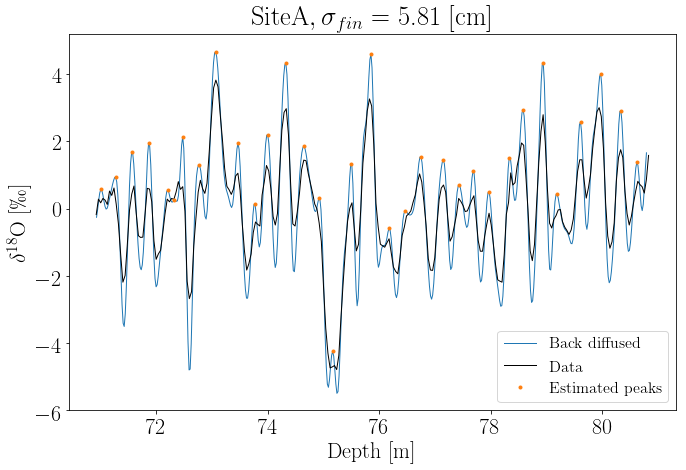

In [26]:

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(depth1, data, lw=1, label='Back diffused')
ax.plot(depth_LT, d18O_LT-np.mean(d18O_LT),color='k', lw=1, label = 'Data')
ax.plot(depth1[peaks], data[peaks],'.',lw=1, label='Estimated peaks')
ax.set(xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]', title=site+'$, \sigma_{fin} =$ ' + f'{diffLen*100:.2f} [cm]')
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig(site+ '_peaks.jpg')

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + site + '_BackDiffused_Y32.jpg')

array([0.26736772, 0.28646542, 0.30556311, 0.3437585 , 0.11458617,
       0.15278156, 0.28646542, 0.30556311, 0.40105159, 0.30556311,
       0.22917233, 0.32466081, 0.32466081, 0.26736772, 0.24827003,
       0.32466081, 0.3628562 , 0.32466081, 0.28646542, 0.28646542,
       0.40105159, 0.28646542, 0.24827003, 0.28646542, 0.3628562 ,
       0.24827003, 0.3628562 , 0.24827003, 0.42014928, 0.3628562 ,
       0.3628562 , 0.28646542])

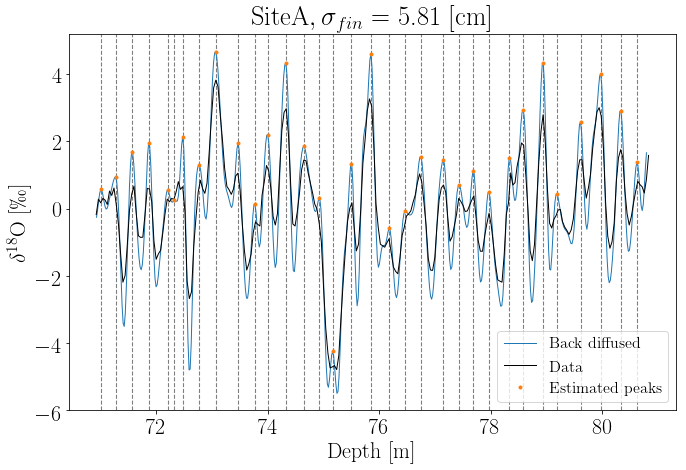

In [36]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(len(peaks)):
    ax.axvline(x=depth1[peaks[i]], color='k', lw=1.1, ls='--', alpha=0.5)
    
ax.plot(depth1, data, lw=1, label='Back diffused')
ax.plot(depth_LT, d18O_LT-np.mean(d18O_LT),color='k', lw=1, label = 'Data')
ax.plot(depth1[peaks], data[peaks],'.',lw=1, label='Estimated peaks')

ax.set(xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]', title=site+'$, \sigma_{fin} =$ ' + f'{diffLen*100:.2f} [cm]')
ax.legend(fontsize=16)
fig.tight_layout()

if saveFigs:
    fig.savefig(site+ '_peaks.jpg')
np.diff(depth1[peaks])

#### Plot best sigma - from peak detection and theoretical.

In [28]:
print(f'Max theoretical sigma: {sigmaMax_theo:.3f}')
print(f'Min theoretical sigma: {sigmaMin_theo:.3f}')
print(f'Fitted estimated sigma: {sigma_fit:.3f}')
print(f'Final optimized sigma: {diffLen:.3f}')

Max theoretical sigma: 0.079
Min theoretical sigma: 0.077
Fitted estimated sigma: 0.073
Final optimized sigma: 0.058


In [29]:
depthMax, dataMax = decon_inst.deconvolve(sigmaMax_theo)
depthMin, dataMin = decon_inst.deconvolve(sigmaMin_theo)
depthFit, dataFit = decon_inst.deconvolve(sigma_fit)
depthFin, dataFin = decon_inst.deconvolve(diffLen)

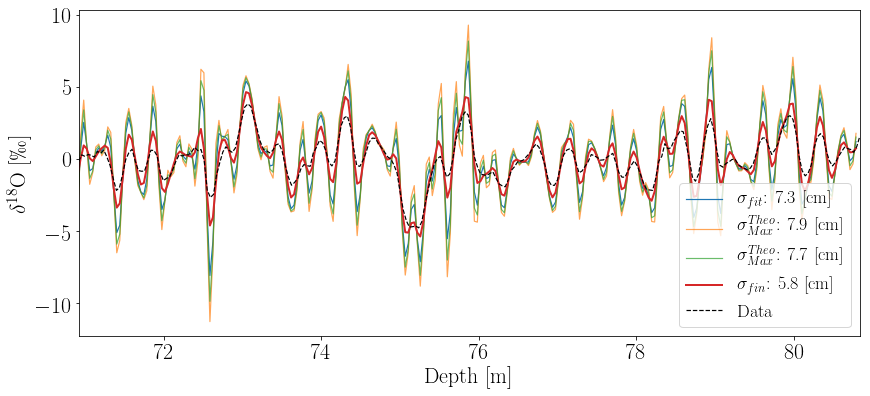

In [30]:
figAllSigma, axAllSigma = plt.subplots(figsize=(14,6))

axAllSigma.plot(depthFit, dataFit, label= '$\sigma_{fit}$'+f': {sigma_fit*100:.1f} [cm]',lw=1.2)
axAllSigma.plot(depthMax, dataMax, label= '$\sigma_{Max}^{Theo}$' + f': {sigmaMax_theo*100:.1f} [cm]', alpha=0.7,lw=1.2)
axAllSigma.plot(depthMin, dataMin, label= '$\sigma_{Max}^{Theo}$' + f': {sigmaMin_theo*100:.1f} [cm]', alpha=0.7,lw=1.2)
axAllSigma.plot(depthFin, dataFin, label= '$\sigma_{fin}$' + f': {diffLen*100:.1f} [cm]',lw=2)
axAllSigma.plot(depth_LT, d18O_LT-np.mean(d18O_LT), color='k', ls='--',lw=1.2, label='Data')
axAllSigma.set(xlim=(depth_LT.min(),depth_LT.max()), xlabel='Depth [m]', ylabel='$\delta^{18}$O [\permil]')
axAllSigma.legend(fontsize=18)

if saveFigs:
    figAllSigma.savefig('../../WrittenWork/Figures/' + site + '_BackDiffused_AllSigmaEst.jpg')

# Interpolation after deconvolution

In [31]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in, Delta_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = Delta_in
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat, Delta

In [32]:
dhat, xhat, Delta = interpCores(depthFin.min(), depthFin.max(), pd.Series(depthFin), pd.Series(dataFin), 0.005)

In [33]:
from scipy import signal

peaks1 = signal.find_peaks(dataFin)[0]
peaks_interp = signal.find_peaks(xhat)[0]



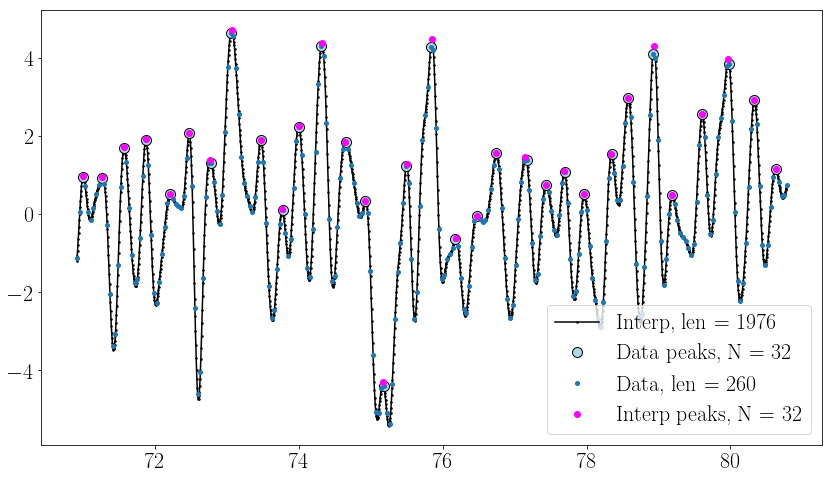

In [34]:
figInterp2, axInterp2 = plt.subplots(figsize=(14,8))

axInterp2.plot(dhat,xhat, '-', marker='.', ms=3, color='k',label=f'Interp, len = {len(dhat)}')
axInterp2.plot(depthFin[peaks1], dataFin[peaks1], 'o', ms=10, markeredgecolor='k', color='lightblue', label=f'Data peaks, N = {len(dataFin[peaks1])}')


axInterp2.plot(depthFin, dataFin,'o', ms=4, label=f'Data, len = {len(depthFin)}')
axInterp2.plot(dhat[peaks_interp], xhat[peaks_interp], 'o', ms=6, color='magenta', label=f'Interp peaks, N = {len(xhat[peaks_interp])}')



axInterp2.legend()

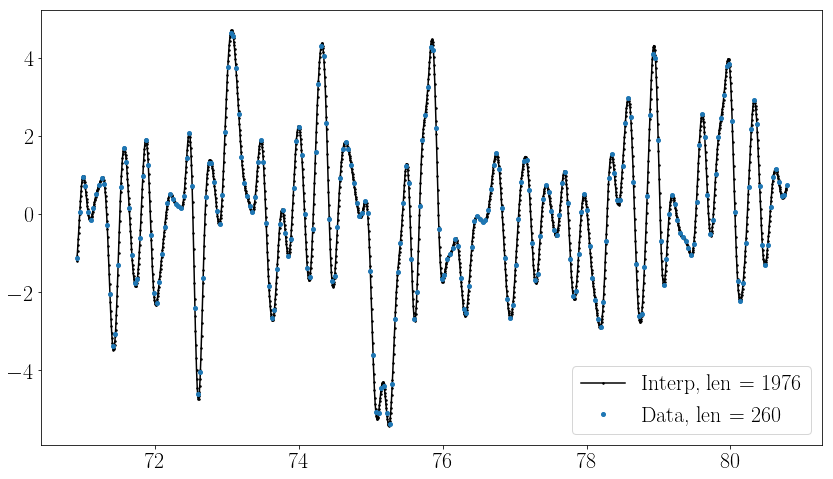

In [35]:
figInterp2, axInterp2 = plt.subplots(figsize=(14,8))

axInterp2.plot(dhat,xhat, '-', marker='.', ms=3, color='k',label=f'Interp, len = {len(dhat)}')
#axInterp2.plot(depthFin[peaks1], dataFin[peaks1], 'o', ms=10, markeredgecolor='k', color='lightblue', label=f'Data peaks, N = {len(dataFin[peaks1])}')


axInterp2.plot(depthFin, dataFin,'o', ms=4, label=f'Data, len = {len(depthFin)}')
#axInterp2.plot(dhat[peaks_interp], xhat[peaks_interp], 'o', ms=6, color='magenta', label=f'Interp peaks, N = {len(xhat[peaks_interp])}')



axInterp2.legend()

# Generate data for diffusion length v. N peaks

In [ ]:
# sites = ['Crete', 'SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']
# for i in range(len(sites)):
#     print('\nSite: ' + sites[i] + '\n')
#     getDiffLen_V_Npeaks(site_in=sites[i], diffLen_start=0.005, diffLen_end=0.15)


In [ ]:
from StabilityTests import getDiffLen_V_Npeaks

In [ ]:

Sites = ['Crete', 'SiteA', 'SiteB', 'SiteD','SiteE', 'SiteG']
site='SiteA'
StabTest = pd.read_csv('../Data/'+site + '_DiffLensVpeaks.txt', sep='\t')

StabTest_upTo32 = pd.read_csv('../Data/'+site + '_DiffLensVpeaks_upTo32.txt', sep='\t')
StabTest_upTo32

#### Plot number of peaks vs. diffusion length.

In [ ]:


fig, ax = plt.subplots(figsize=(8,9))
for i in range(len(Sites)):
    StabTest = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks.txt', sep='\t')
    
    ax.step(StabTest['diffLen'], StabTest['Npeaks'], label=Sites[i])
ax.axhline(y=32,ls='--',color='k', lw=1.2, alpha=0.8,label='N = 32')
ax.set(xlabel='Diffusion Length [m]', ylabel='Number of peaks', xlim=(0.005,0.15))
ax.legend()
fig.tight_layout();


#### Create zoom in plots with defined diff len resulting in < 32 peaks.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 22})
colors = ['magenta','blue','orange','maroon','teal','darkgreen']

for i in range(len(Sites)):
    StabTest = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks.txt', sep='\t')
    
    ax.step(StabTest['diffLen'], StabTest['Npeaks'], label=Sites[i],alpha=0.6,color=colors[i])

ax.axhline(y=32,ls='--',color='k', lw=1.2, alpha=0.8)
ax.set(xlabel='Diffusion Length [m]', ylabel='Number of peaks', xlim=(0.005,0.15))
ax.legend(fontsize=18)



x1 = 0.025
x2 = 0.085
y1 = 15
y2 = 50


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = inset_axes(ax, 6,4, loc=2, bbox_to_anchor=(0.5,0.1,1,1), bbox_transform=ax.figure.transFigure)#loc=5) # zoom = 2
for i in range(len(Sites)):
    StabTest = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks.txt', sep='\t')
    StabTest_upTo32 = pd.read_csv('../Data/'+Sites[i] + '_DiffLensVpeaks_upTo32.txt', sep='\t')
    
    DiffLens_32 = np.asarray(StabTest_upTo32['diffLen_upTo32'])
    Npeaks_32 = np.asarray(StabTest_upTo32['Npeaks_upTo32'])
    
    axins.step(StabTest['diffLen'], StabTest['Npeaks'], label=Sites[i], color=colors[i], alpha=0.3)

    if StabTest_upTo32['diffLen_upTo32'].any():
        axins.axvline(x=DiffLens_32[-1], lw=2, alpha=0.9, color=colors[i],ls='--')
        axins.step(DiffLens_32, Npeaks_32, label=Sites[i], color=colors[i])
        if (i==0)or(i==2):
            axins.text(DiffLens_32[-1]-0.0025,50+2.5, f'{DiffLens_32[-1]:.3f}',fontsize=16, color=colors[i])
        elif (i==5):
            axins.text(DiffLens_32[-1]-0.0025,50+0.5, f'{DiffLens_32[-1]:.3f}',fontsize=16, color=colors[i])
        elif (i==1)or(i==4):
            axins.text(DiffLens_32[-1]-0.0025,50+0.5, f'{DiffLens_32[-1]:.3f}',fontsize=16, color=colors[i])
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


#fig.savefig('../WrittenWork/Figures/' + 'NpeaksVdiffLen_zoomIn.jpg', bbox_inches = 'tight')

# Test: Theoretical Diffusion Length Estimate

In [ ]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [ ]:
site = 'SiteA'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
N_InInt = 32

In [ ]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
dataMin, peaksMin, N_peaksMin, dataMax, peaksMax, N_peaksMax = inst.BackDiffuse_Theo()

depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

In [ ]:
depth0 = dataMin['depth']
data0 = dataMin['d18O']
depth1 = dataMax['depth']
data1 = dataMax['d18O']
#troughs = signal.find_peaks(-dataOpt)[0]
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depth0,data0, label='$\sigma_{Theo}^{min}$ = ' + f'7.66, N = {N_peaksMin}',zorder=-1, color='orange', alpha=0.7)
plt.plot(depth1,data1, label='$\sigma_{Theo}^{max}$ = ' + f'7.88, N = {N_peaksMax}',zorder=-1, color='green', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)
#, Nt = {len(troughs)}
plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]', title=site,xlim=(min(depth_LT),max(depth_LT)))
plt.scatter(depth0[peaksMin],data0[peaksMin], color='orange',zorder=1, s=20, alpha=0.7)
plt.scatter(depth1[peaksMax],data1[peaksMax], color='maroon',zorder=1, s=20, alpha=0.7)
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='b',zorder=1, s=25)
#plt.scatter(depthOpt[troughs],dataOpt[troughs], color='k',zorder=1, s=25)


#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')